In [1]:
# To import your own module from a subdirectory, you can use sys.path or install as a package.
# Example using sys.path (assuming HP-Operation is a folder with __init__.py):

import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import os
sys.path.append(os.path.abspath("../../src/"))  # now src is on sys.path
import HP_Operation as tool
import OpenMeteo_API as openMeteo
import RC_Model as rc_model

%load_ext autoreload
%autoreload 2

In [2]:
# Set random seed for reproducibility
np.random.seed(0)

# Path to your Excel file
file_path = 'data/PV_Profile_Cyprus.xlsx'

# Read the Excel file into a DataFrame
PV_profile_Cyprus = pd.read_excel(file_path,index_col=0) # 24 hour per kw historical rooftop production for different months 
PV_profile_Cyprus=PV_profile_Cyprus*1.3

file_path = 'data/annual_consumption_profiles_cyprus.npy'  # A lot of load profiles from nandos (Australia)
Load_profile_cyprus=np.load(file_path)/1000
Load_profile_cyprus=Load_profile_cyprus*1.1
# Load_profile_cyprus=load_profile_cyprus/1000

# Read the specified sheet into a DataFrame
PV_Data = pd.read_excel('data/PV_Insallation_Historical_Data.xlsx')

# Drop rows where 'Power' or 'Phase' columns have NaN values
PV_Data = PV_Data.dropna(subset=['Power', 'Phase'])

In [3]:
# Reshape to (68, 17568)
profiles = Load_profile_cyprus.reshape(68, -1)
dt_index = pd.date_range("2016-01-01", periods=366*48, freq="30min")

# Monthly means per customer 
monthly_means = pd.DataFrame(index=range(68), columns=range(1, 13))
for customer_id in range(68):
    s = pd.Series(profiles[customer_id], index=dt_index)
    for month in range(1, 13):
        monthly_means.loc[customer_id, month] = s[s.index.month == month].mean()

monthly_means = monthly_means.astype(float)

# seasonal mean values
winter_mean = monthly_means[[12, 1, 2]].sum(axis=1)
autumn_mean = monthly_means[[9, 10, 11]].sum(axis=1)

# Thermal customer = winter/summer > threshold
threshold = 1.6
heating_flags = (winter_mean / autumn_mean) > threshold
heating_customers = monthly_means.index[heating_flags].tolist()

print("❄️ Suspected heating customers:", heating_customers)

# Customer without electric heating consumption
non_heating_customers = np.setdiff1d(np.arange(68), heating_customers)

# Kepp only non-heating customers
profiles_no_heating = profiles[non_heating_customers]  # shape (N, 17568)

❄️ Suspected heating customers: [7, 14, 19, 23, 27, 32, 33, 34, 42, 46, 52]


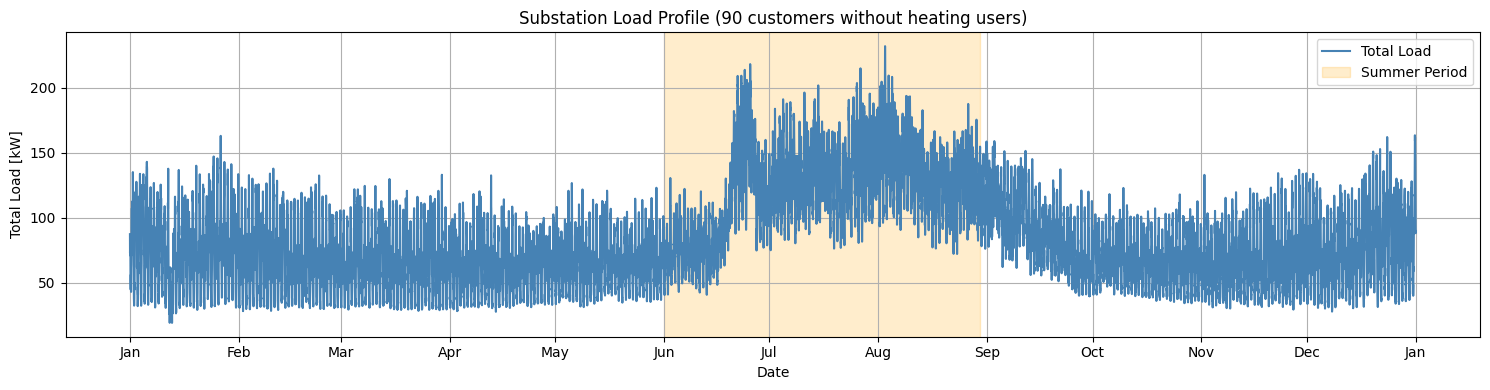

In [4]:
substation_customers=90

# profiles_no_heating: has shape (N_customers, 17568)
N_customers = profiles_no_heating.shape[0]  # e.g. 63

# 1. All Customers without repeatition
unique_customers = np.arange(N_customers)

# 2. How many extra customers do we need to reach substation_customers?
N_extra = substation_customers - N_customers

# 3. Randomly choose extra customer (repeatition allowed)
extra_customers = np.random.choice(N_customers, size=N_extra, replace=True)

# 4. Final list of customers
total_customers = np.concatenate([unique_customers, extra_customers])

# 5. Total load profile
substation_profiles = profiles_no_heating[total_customers]  # shape = (90, 17568)
substation_total_load = substation_profiles.sum(axis=0)

# 6. Create series for plotting
time_index = pd.date_range("2016-01-01", periods=17568, freq="30min")
load_series = pd.Series(substation_total_load, index=time_index)

# 7. Plot
plt.figure(figsize=(15, 4))
plt.plot(load_series, color='steelblue', label='Total Load')

# Highlight summer period
plt.axvspan(pd.Timestamp('2016-06-01'), pd.Timestamp('2016-08-30'), 
            color='orange', alpha=0.2, label='Summer Period')

plt.title("Substation Load Profile (90 customers without heating users)")
plt.xlabel("Date")
plt.ylabel("Total Load [kW]")
plt.grid(True)
plt.legend()
# Format x-axis to show only month names
month_formatter = mdates.DateFormatter('%b')  # e.g. Jan, Feb, ...
plt.gca().xaxis.set_major_formatter(month_formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()

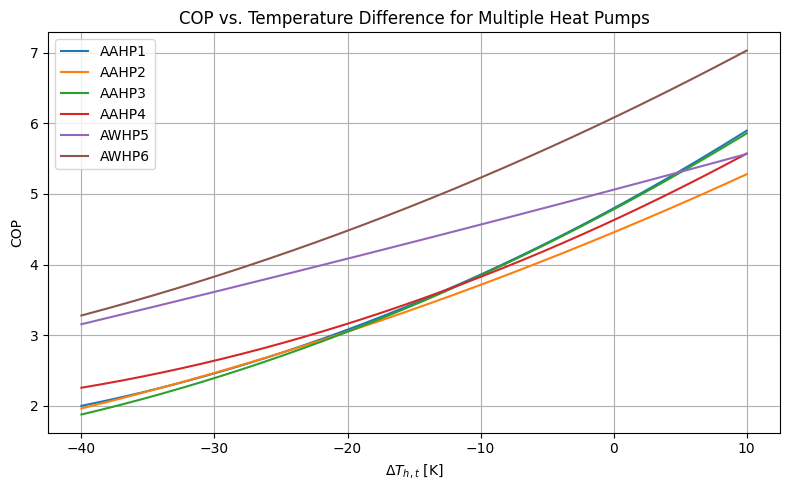

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def cop_curve(DeltaT, a0, a1, a2):
    """
    Calculate COP for a given DeltaT and coefficients.
    COP = a0 - a1 * DeltaT - a2 * (DeltaT)^2
    """
    return a0 - a1 * DeltaT - a2 * (DeltaT ** 2)

def plot_cop_curves(hp_params_list, DeltaT_range, labels=None):
    """
    Plot COP curves for multiple heat pumps.
    
    hp_params_list: list of (a0, a1, a2) tuples
    DeltaT_range: np.array of DeltaT values
    labels: list of labels for each HP (optional)
    """
    plt.figure(figsize=(8, 5))
    for i, (a0, a1, a2) in enumerate(hp_params_list):
        cop = cop_curve(DeltaT_range, a0, a1, a2)
        label = labels[i] if labels is not None else f"HP {i+1}"
        plt.plot(DeltaT_range, cop, label=label)
    plt.xlabel(r'$\Delta T_{h,t}$ [K]')
    plt.ylabel('COP')
    plt.title('COP vs. Temperature Difference for Multiple Heat Pumps')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# Define DeltaT range (e.g., 0 to 40 K)
DeltaT_range = np.linspace(-40, 10, 200)

# Define heat pump parameters: (a0, a1, a2)
hp1 = (4.7972, -0.1019, -0.0008)
hp2 = (4.4564, -0.0783, -0.0004)
hp3 = (4.782, -0.1006, -0.0007)
hp4 = (4.6293, -0.0873, -0.0007)
hp5 = (5.06, -0.05, -0.00006)
hp6 = (6.08, -0.09, -0.0005)

# Plot all three on the same plot
plot_cop_curves([hp1, hp2, hp3, hp4, hp5, hp6], DeltaT_range, labels=["AAHP1", "AAHP2", "AAHP3", "AAHP4", "AWHP5", "AWHP6"])

# To add more, just append more (a0, a1, a2) tuples to the list and add a label.


## Model 1 of Abdelrahman Ayad [Modeling ofheat pumps load profiles for power systems integration]. 

### This methodology was really bad from the structure of it. It is now neccessary to implement it however i will keep it here to test it if needed.

In [ ]:
# Keep only the winter period: before June and after August
winter_series = load_series[(load_series.index < "2016-06-01") | (load_series.index >= "2016-09-01")]
winter_series

# Get historic temperature data for the full year
temp = openMeteo.get_historic_temperature_data(35.1856, 33.3823, start_date="2016-01-01", end_date="2017-01-01")

# Filter to only the winter period: before June and after August
winter_temp = temp[(temp['date'] < "2016-06-01") | (temp['date'] >= "2016-09-01")]

# Set index to match winter_series (datetime index, 30min freq) and interpolate missing 30min values
winter_temp = winter_temp.set_index('date')
winter_temp = winter_temp.reindex(winter_series.index)
winter_temp = winter_temp.interpolate(method='time')

from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Compute the minimum winter load for each time interval (e.g., all 00:00, all 00:30, etc.)
# Extract the time of day for each index
time_of_day = winter_series.index.time
# Group by time of day and get the min for each group
winter_min_by_time = winter_series.groupby(time_of_day).min()
# Map the min value for each time of day back to the original index
winter_min_aligned = pd.Series([winter_min_by_time[t] for t in time_of_day], index=winter_series.index)

# 2. Subtract the time-of-day minimum from the winter load to get the temperature-dependent component
winter_temp_dependent_load = winter_series - winter_min_aligned

# 3. Prepare the temperature data (reshape for sklearn)
X_temp = winter_temp['temperature_2m'].values.reshape(-1, 1)
y_load = winter_temp_dependent_load.values

# 4. Fit a linear regression model: L_s = alpha + beta * T
reg = LinearRegression()
reg.fit(X_temp, y_load)

alpha = reg.intercept_
beta = reg.coef_[0]

print(f"Regression parameters: alpha = {alpha:.4f}, beta = {beta:.4f}")

# Optionally, you can get the fitted values (temperature-dependent load)
fitted_load = reg.predict(X_temp)




## Model 2 of Abdelrahman Ayad [Modeling ofheat pumps load profiles for power systems integration]. 
